# 6. Drill into the TI anomaly

In [1]:
from IPython.display import display, HTML
import matplotlib as mpl
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np
import scipy
import os
import feather
import statsmodels.tsa.stattools as tsa
import pandas as pd
import seaborn as sns
from scipy import stats
sns.set(style='ticks', rc={'axes.grid':True,
                           'xtick.labelsize': 'medium',
                           'ytick.labelsize': 'medium',
#                            'font.size': 15,
                          })
# mpl.rcParams.update({'font.size': 15})
# plt.rc('ytick', labelsize='small') 


# assume the notebook is in the right place and set up the plot path
analysis_dir = _dh[0]
assert analysis_dir.endswith(os.path.join('em-2020','analysis'))
plot_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'tex', 'plots'))
data_dir = os.path.realpath(os.path.join(analysis_dir, '..', 'data'))

In [2]:
SAVE = True

def save_table(table, file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        with open(path, 'w') as fd:
            fd.write(table.to_latex(**kwargs))
        
def save_fig(file, **kwargs):
    if SAVE:
        path = os.path.join(plot_dir, file)
        plt.savefig(path, metadata={'CreationDate': None})

def load_data(country, version='current'):
    data_file = os.path.join(data_dir, 'WB_{}_{}.csv'.format(country, version))
    data_raw = pd.read_csv(data_file, index_col='year')
    cols = ['ISG', 'TO', 'TI', 'P_GDP', 'P_GDPb', 'EI', 'EIb']
    if 'EIc' in data_raw:
        cols.append('EIc')

    return data_raw[cols]
    
def summary_stats(data, country, version):
    stats = ref_data.describe().T[['min', 'max', 'mean', 'std', 'count']]
    stats['count'] = stats['count'].astype(int)
    with pd.option_context('display.float_format', '{:.2f}'.format):
        display(stats)
        print(stats.to_latex())
#         save_table(stats, '_'.join((country, version, 'descriptive_statistics.tex')))

In [3]:
def plot_corr(data, figsize=None, **kwargs):
    corr = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[0])
    significance = data.corr(lambda x, y: scipy.stats.pearsonr(x,y)[1])
    corr_text = corr.applymap('{:.3f}'.format) + np.where(significance < .01, '*', '')

    mask = np.triu(np.ones_like(corr, dtype=np.bool))
    if figsize is None:
        figsize=np.array([1, 0.75]) * corr.shape[0] + np.array([kwargs.get('cbar', True) * 1.5, 0])
    f, ax = plt.subplots(figsize=figsize)
    cmap = sns.diverging_palette(220, 10, s=50, l=85, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, annot=corr_text, fmt='', mask=mask, cmap=cmap, 
                square=False, linewidths=.25, vmin=-1, vmax=1, **kwargs)
    ax.set_yticklabels(ax.get_yticklabels(), fontdict={'verticalalignment': 'center'})

In [4]:
countries = ['BGD', 'IND', 'GBR']
raw_data = pd.concat([load_data(c, 'current') for c in countries],
                     keys=countries, names=['country', 'year'])

In [5]:
log_cols = ['EI', 'EIb', 'EIc', 'P_GDP', 'P_GDPb', 'TI']

log_data = raw_data.copy()
log_data[log_cols] = np.log(log_data[log_cols])
logdiff_data = log_data.groupby(level='country').diff().loc[pd.IndexSlice[:, 1986:], :]
log_data = log_data.loc[pd.IndexSlice[:, 1986:], :]
log_data.groupby(level='country').apply(lambda x: x.xs(1992, level='year'))

,,ISG,TO,TI,P_GDP,P_GDPb,EI,EIb,EIc
country,country,,,,,,,,
BGD,BGD,21.717891,19.934006,5.081404,5.682372,6.854642,-0.872410,-2.044680,NaN
GBR,GBR,26.769470,46.060642,10.191932,9.927554,9.765868,-1.715603,-1.553917,-2.039859
IND,IND,26.792743,18.433099,8.138565,5.758756,7.199428,0.135862,-1.304809,-1.658402


Text(0, 0.5, 'TI (others)')

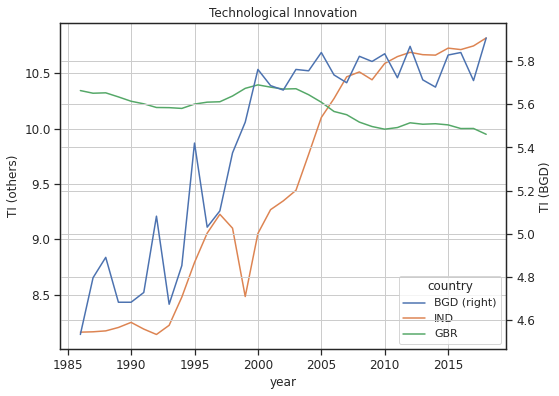

In [6]:
f, ax = plt.subplots(figsize=(8, 6))
log_data['TI'].unstack(level=0).plot(ax=ax, secondary_y='BGD', grid=True)
plt.title('Technological Innovation')
plt.ylabel('TI (BGD)')
ax.set_ylabel('TI (others)')


Text(0, 0.5, 'TI (others)')

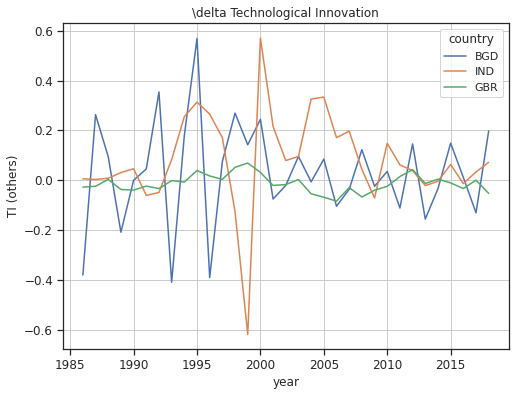

In [7]:
f, ax = plt.subplots(figsize=(8, 6))
logdiff_data['TI'].unstack(level=0).plot(ax=ax, grid=True)
plt.title('\delta Technological Innovation')
plt.ylabel('TI (BGD)')
ax.set_ylabel('TI (others)')

In [8]:
log_ti = logdiff_data['TI'].unstack(level='country').dropna()
logdiff_ti = logdiff_data['TI'].unstack(level='country').dropna()
logdiff_ti.columns.name = None
logdiff_ti.reset_index(inplace=True)
logdiff_ti.tail()

,year,BGD,IND,GBR
28,2014,-0.033560,-0.004122,0.004437
29,2015,0.148773,0.063380,-0.010427
30,2016,0.011696,-0.013250,-0.033084
31,2017,-0.130215,0.033286,0.000589
32,2018,0.197656,0.071908,-0.052601


In [9]:
%get data_dir --from em-2020
%get log_cols --from em-2020
suppressMessages({
library(data.table)
library(dplyr)
library(tseries)
library(plm)
library(feather)
library(forecast)
})
data.raw <- read.csv(file.path(data_dir, 'WB_BGD_current.csv'))


data.log <- copy(data.raw)
data.log[log_cols[log_cols != 'EIc']] <- log(data.raw[log_cols[log_cols != 'EIc']])

# data.logdiff <- diff(as.matrix(log(data.raw)))
data.logdiff <- cbind(data.raw[-1,'year', drop=FALSE], diff(as.matrix(subset(data.log, select=-year))))

data <- subset(data.raw, year >= 1986)
data.log <- subset(data.log, year >= 1986)
data.logdiff <- subset(data.logdiff, year >= 1986)


In [10]:
%get data.raw data.log data.logdiff --from R
(raw_data.xs('BGD', level='country')
 .reset_index().dropna(how='all', axis='columns')
 .subtract(data_raw)).abs().max().max()

Variable data.raw is put to SoS as data_raw
Variable data.log is put to SoS as data_log
Variable data.logdiff is put to SoS as data_logdiff


4.547473508864641e-13

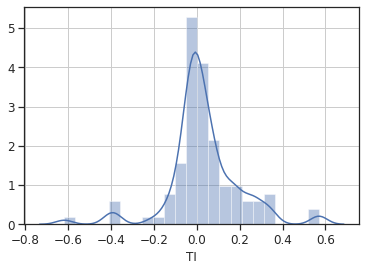

In [11]:
sns.distplot(logdiff_data['TI']);


	Jarque Bera Test

data:  ti
X-squared = 0.48062, df = 2, p-value = 0.7864


Warning message in adf.test(ti, k = 1):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ti
Dickey-Fuller = -7.932, Lag order = 1, p-value = 0.01
alternative hypothesis: stationary


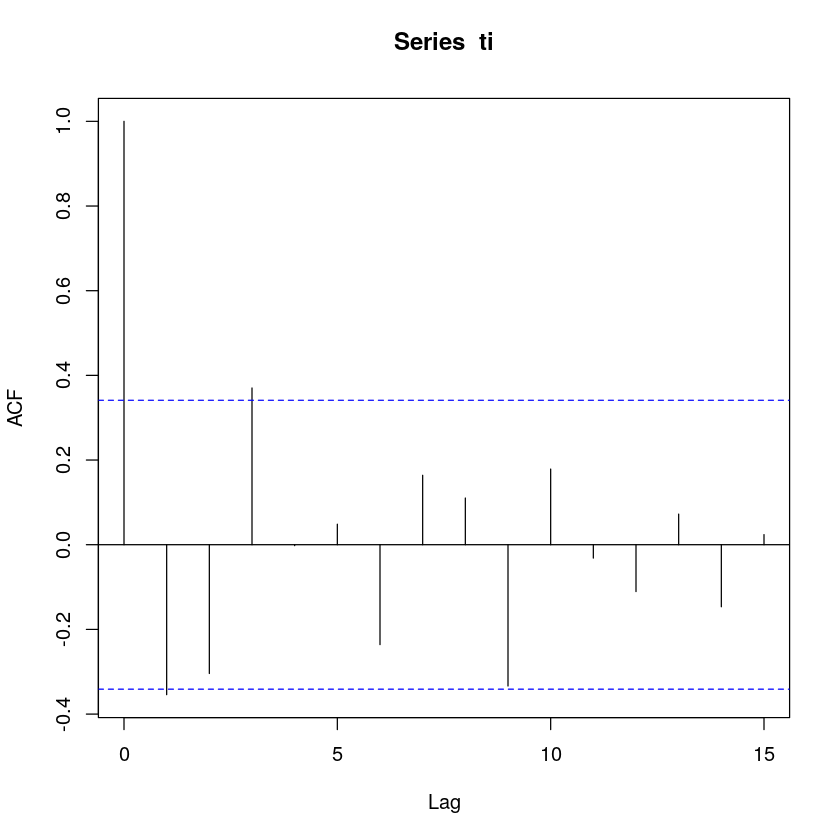

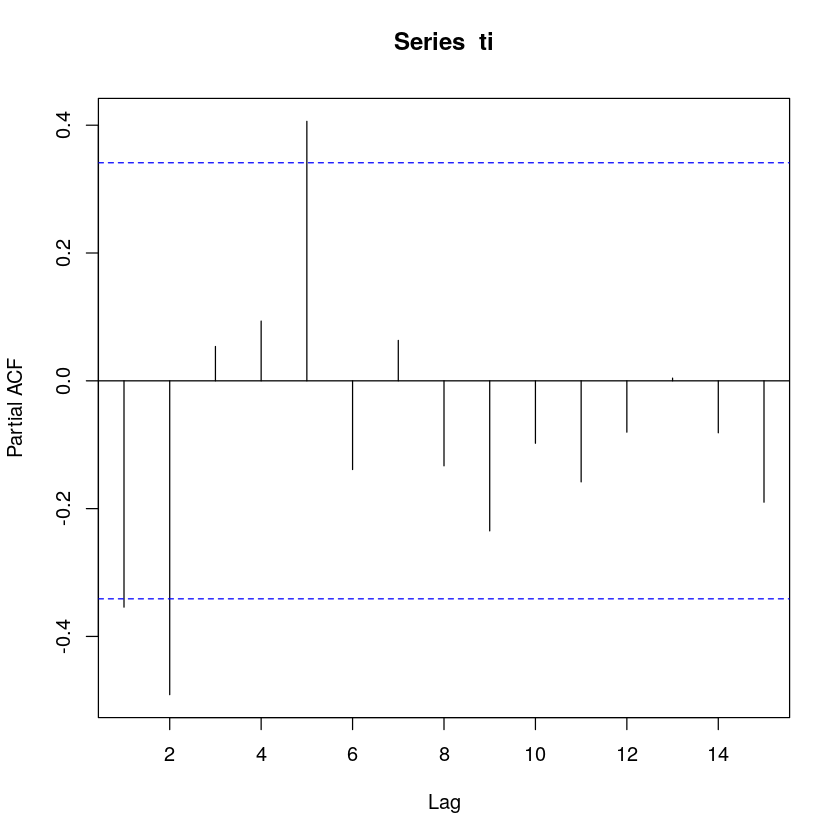

In [12]:
ti = na.omit(data.logdiff$TI)
jarque.bera.test(ti)
adf.test(ti, k=1)
acf(ti, plot=TRUE)
pacf(ti, plot=TRUE)

In [13]:
(arima.model.1 <- Arima(ti, order=c(1,0,0), method='ML'))
(arima.model.2 <- Arima(ti, order=c(2,0,0), method='ML'))
(arima.model.5 <- Arima(ti, order=c(5,0,0), method='ML'))

Series: ti 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
          ar1    mean
      -0.3989  0.0323
s.e.   0.1697  0.0238

sigma^2 estimated as 0.03814:  log likelihood=8.02
AIC=-10.03   AICc=-9.21   BIC=-5.55

Series: ti 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1      ar2    mean
      -0.5749  -0.5390  0.0336
s.e.   0.1542   0.1518  0.0136

sigma^2 estimated as 0.0284:  log likelihood=13.09
AIC=-18.19   AICc=-16.76   BIC=-12.2

Series: ti 
ARIMA(5,0,0) with non-zero mean 

Coefficients:
          ar1      ar2     ar3     ar4     ar5    mean
      -0.5681  -0.5005  0.2989  0.3077  0.4184  0.0294
s.e.   0.1596   0.1724  0.1871  0.1765  0.1552  0.0225

sigma^2 estimated as 0.02512:  log likelihood=16.37
AIC=-18.74   AICc=-14.26   BIC=-8.26


	Ljung-Box test

data:  Residuals from ARIMA(2,0,0) with non-zero mean
Q* = 7.8544, df = 4, p-value = 0.09706

Model df: 3.   Total lags used: 7



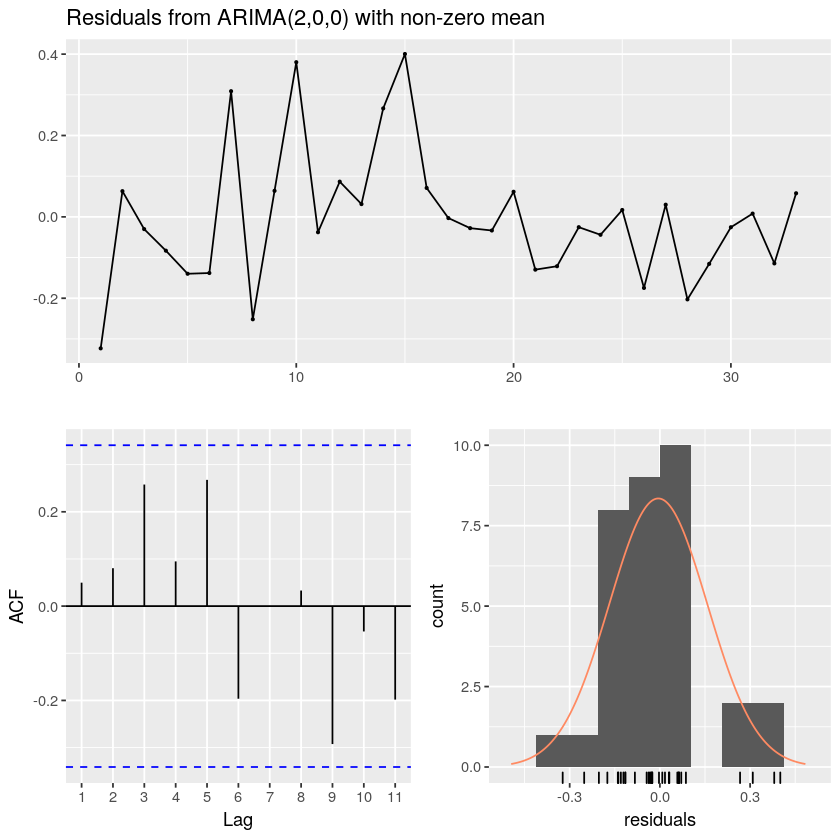

In [14]:
arima.model <- arima.model.2
checkresiduals(arima.model)

In [15]:
summary(arima.model)

Series: ti 
ARIMA(2,0,0) with non-zero mean 

Coefficients:
          ar1      ar2    mean
      -0.5749  -0.5390  0.0336
s.e.   0.1542   0.1518  0.0136

sigma^2 estimated as 0.0284:  log likelihood=13.09
AIC=-18.19   AICc=-16.76   BIC=-12.2

Training set error measures:
                       ME      RMSE       MAE  MPE MAPE      MASE       ACF1
Training set -0.005301665 0.1606761 0.1172297 -Inf  Inf 0.4582689 0.04966678


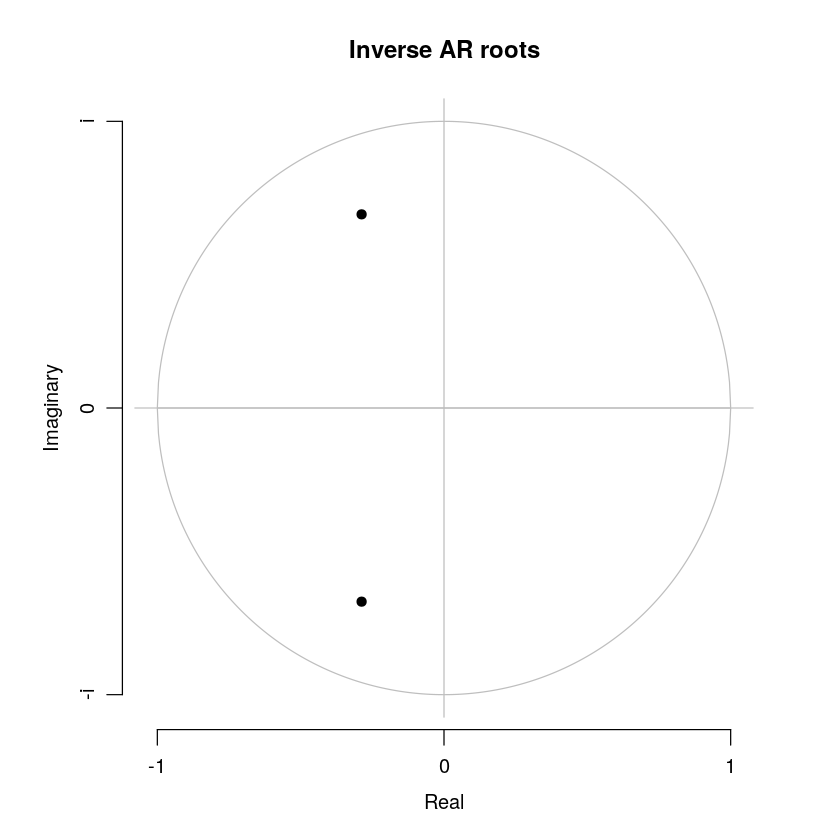

In [16]:
plot(arima.model)